In [1]:
import torch
import time
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import networkx as nx
from utils.clocks.global_clock import clock, GLOBAL_TIME, GLOBAL_WAVE, GLOBAL_PULSE, GLOBAL_SPIKE
from utils.neurons.LIFNeurons.leaky_integrate_and_fire import LIFNeuron, LIFNeuronGroup
from utils.sypanses.synapses import FeedForwardSynapses, Synapse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())


def visualize_network(neurons, synapses):
    G = nx.DiGraph()

    for i in range(len(neurons)):
        G.add_node(f"N{i}")

    for syn in synapses:
        pre_idx = neurons.index(syn.pre)
        post_idx = neurons.index(syn.post)
        G.add_edge(f"N{pre_idx}", f"N{post_idx}", weight=syn.weight)

    pos = nx.spring_layout(G, seed=42)
    edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in G.edges(data=True)}

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title("Neuron Network Topology")
    plt.show()


def visualize_per_neuron_network(neuron_groups, synapse_layers):
    G = nx.DiGraph()
    group_prefix = ['I', 'H', 'O', 'X']  # add more if more groups
    group_nodes = []

    # Add neurons from each group
    for g_idx, group in enumerate(neuron_groups):
        prefix = group_prefix[g_idx]
        nodes = [f"{prefix}_{i}" for i in range(group.size)]
        G.add_nodes_from(nodes)
        group_nodes.append(nodes)

    # Add synapse connections per neuron
    for s_idx, syn in enumerate(synapse_layers):
        pre_nodes = group_nodes[s_idx]
        post_nodes = group_nodes[s_idx + 1]
        weights = syn.weights

        for post_idx, post_node in enumerate(post_nodes):
            for pre_idx, pre_node in enumerate(pre_nodes):
                w = weights[post_idx, pre_idx].item()
                if abs(w) > 1e-3:  # skip tiny weights for clarity
                    G.add_edge(pre_node, post_node, weight=w)

    # Layout with layers aligned left-to-right
    pos = {}
    x_spacing = 2.0
    y_spacing = 0.5
    for layer_idx, nodes in enumerate(group_nodes):
        for i, node in enumerate(nodes):
            pos[node] = (layer_idx * x_spacing, -i * y_spacing)

    edge_weights = nx.get_edge_attributes(G, 'weight')
    edge_labels = {e: f"{w:.1f}" for e, w in edge_weights.items()}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_size=300, node_color='lightblue', font_size=8, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.title("Per-Neuron Spiking Network Topology")
    plt.axis('off')
    plt.tight_layout()
    plt.show()



def plot_neurons(timestamp, neuron_v, neuron_output):
    num_neurons = len(neuron_v)
    fig, axs = plt.subplots(num_neurons, 2, figsize=(12, num_neurons * 2), sharex=True)

    # Ensure axs is 2D even if there's only 1 neuron
    if num_neurons == 1:
        axs = axs.reshape(1, 2)

    for i in range(num_neurons):
        # Voltage subplot
        axs[i][0].plot(timestamp, neuron_v[i], label=f"V_neuron_{i}", color='tab:blue')
        axs[i][0].set_ylabel("Voltage")
        axs[i][0].set_title(f"Neuron {i} Voltage")
        axs[i][0].grid(True)

        # Spike subplot
        axs[i][1].plot(timestamp, neuron_output[i], label=f"Spikes_neuron_{i}", color='tab:red', drawstyle='steps-post')
        axs[i][1].set_ylabel("Spike")
        axs[i][1].set_yticks([0, 1])
        axs[i][1].set_title(f"Neuron {i} Spikes")
        axs[i][1].grid(True)

        if i == num_neurons - 1:
            axs[i][0].set_xlabel("Time (s)")
            axs[i][1].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()

PyTorch version: 2.5.1
CUDA available: True
Number of GPUs: 1


In [2]:

def create_one_to_one_synapses(neurons, weight=1.0, random_weight=True):
    synapses = []
    for i in range(len(neurons) - 1):
        if random_weight:
            weight = random.uniform(10.0, 40.0)
        synapses.append(Synapse(pre_neuron=neurons[i], post_neuron=neurons[i+1], weight=weight))
    return synapses

def create_fully_connected_synapses(neurons, weight=1.0, random_weight=True):
    synapses = []
    for i, pre in enumerate(neurons):
        for j, post in enumerate(neurons):
            if random_weight:
                weight = random.uniform(10.0, 40.0)
            if i != j:  # avoid self-connections
                synapses.append(Synapse(pre_neuron=pre, post_neuron=post, weight=weight))
    return synapses

def create_ring_synapses(neurons, k=2, weight=1.0, random_weight=True):
    synapses = []
    N = len(neurons)
    for i in range(N):
        for j in range(1, k+1):
            if random_weight:
                weight = random.uniform(10.0, 40.0)
            pre = neurons[i]
            post_forward = neurons[(i + j) % N]
            post_backward = neurons[(i - j) % N]
            synapses.append(Synapse(pre, post_forward, weight))
            synapses.append(Synapse(pre, post_backward, weight))
    return synapses

def create_sparse_random_synapses(neurons, prob=0.1, weight=1.0, random_weight=True):
    synapses = []
    N = len(neurons)
    for i in range(N):
        for j in range(N):
            if i != j and random.random() < prob:
                if random_weight:
                    weight = random.uniform(10.0, 40.0)
                synapses.append(Synapse(neurons[i], neurons[j], weight))
    return synapses


In [3]:
from torchvision import datasets, transforms

mnist_dataset = datasets.MNIST(root="./data", train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.view(-1))  # flatten to (784,)
                                ]))

# Example image
img, label = mnist_dataset[1]  # img shape: (784,)


def encode_poisson_spike_train(image_tensor, time_steps=100):
    # image_tensor: (784,) with values in [0, 1]
    # returns: spike_train of shape (time_steps, 784)
    return (torch.rand(time_steps, 784, device=image_tensor.device) < image_tensor).to(torch.uint8)


spike_train = encode_poisson_spike_train(img.to(device), time_steps=100)
label

0

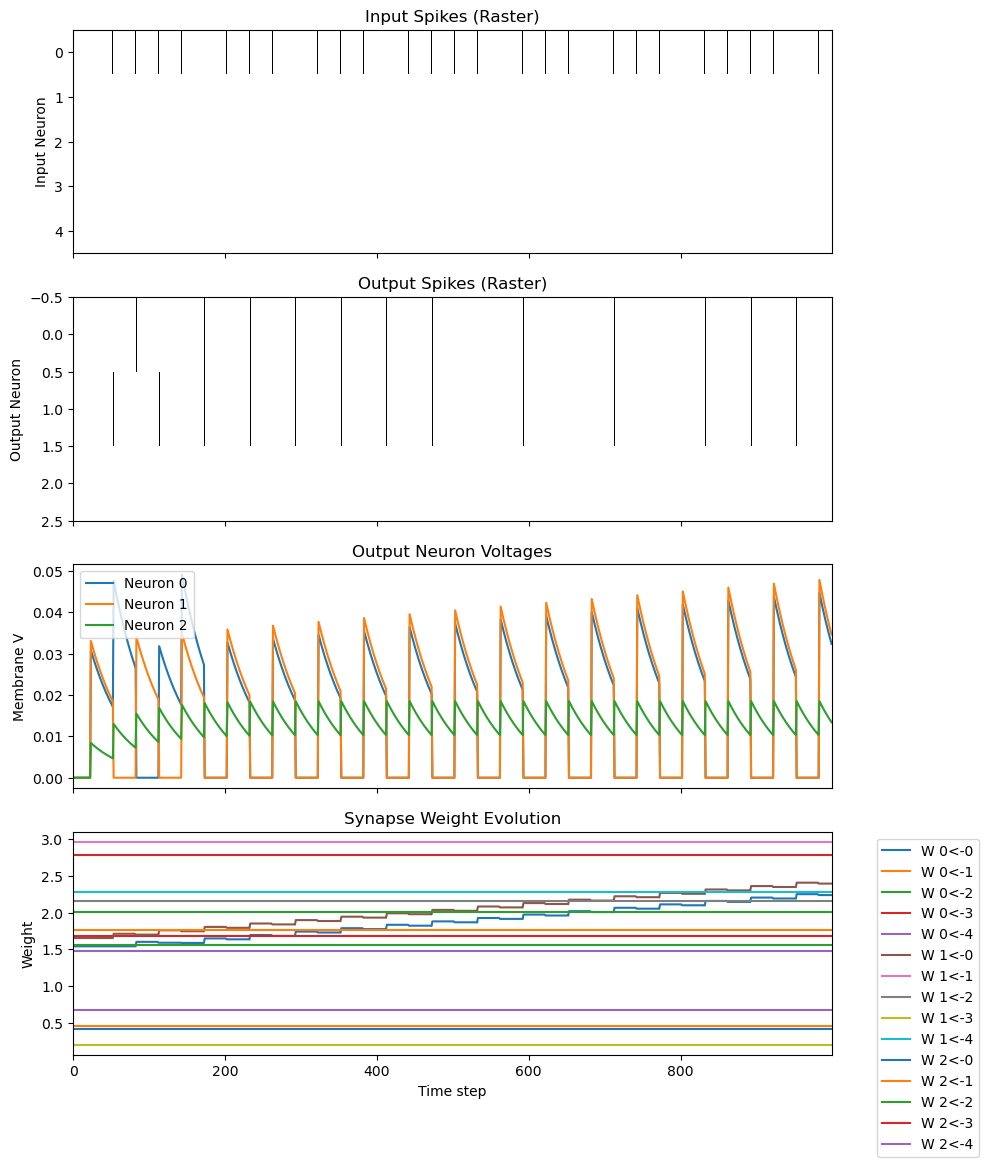

In [2]:
import torch
import matplotlib.pyplot as plt
from utils.clocks.global_clock import Clock
from utils.neurons.LIFNeurons.leaky_integrate_and_fire import LIFNeuronGroup
from utils.synapses.synapses import FeedForwardSynapses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create clock (step mode for reproducibility)
clock = Clock(freq=1.0, sample_rate=1000, amplitude=1.0, real_time=False)

# Create neuron groups
input_neurons = LIFNeuronGroup(size=5, device=device, log_traces=True, tau=5.0)
output_neurons = LIFNeuronGroup(size=3, device=device, log_traces=True, tau=5.0, v_thresh=0.05)

# Create synapses
syn = FeedForwardSynapses(input_neurons, output_neurons, weight_scale=3.0, stdp_lr=0.05)

# Simulation params
dt = 0.1  # 1 ms per step
sim_time = 0.0
steps = 1000

# Store weight evolution
weight_history = []

for step in range(steps):
    clock.step(sim_time)

    # Drive input neurons with periodic current injection
    if step % 10 < 5:
        input_current = torch.tensor([5.0, 0.0, 0.0, 0.0, 0.0], device=device)
    else:
        input_current = torch.zeros(5, device=device)

    input_neurons.receive_input(input_current)
    input_neurons.update(dt)  # update & log

    # Propagate spikes from input to output
    syn.propagate()

    # Update output neurons
    output_neurons.update(dt)

    # Apply STDP
    syn.apply_stdp()
    syn.tick_end()

     # Record weights
    weight_history.append(syn.weights.cpu().clone())

    sim_time += dt

# Convert logs for plotting
in_spikes = torch.stack(input_neurons.spike_trace).cpu()
out_spikes = torch.stack(output_neurons.spike_trace).cpu()
v_trace = torch.stack(output_neurons.full_v_trace).cpu()
weight_history = torch.stack(weight_history).cpu()

# ==== PLOTS ====
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Input spikes raster
axs[0].imshow(in_spikes.T, aspect='auto', cmap='Greys', interpolation='nearest')
axs[0].set_ylabel("Input Neuron")
axs[0].set_title("Input Spikes (Raster)")

# Output spikes raster
axs[1].imshow(out_spikes.T, aspect='auto', cmap='Greys', interpolation='nearest')
axs[1].set_ylabel("Output Neuron")
axs[1].set_title("Output Spikes (Raster)")

# Output voltage trace
for n in range(v_trace.shape[1]):
    axs[2].plot(v_trace[:, n], label=f"Neuron {n}")
axs[2].set_ylabel("Membrane V")
axs[2].set_title("Output Neuron Voltages")
axs[2].legend()

# Synaptic weight evolution
for post_idx in range(weight_history.shape[1]):
    for pre_idx in range(weight_history.shape[2]):
        axs[3].plot(weight_history[:, post_idx, pre_idx], label=f"W {post_idx}<-{pre_idx}")
axs[3].set_ylabel("Weight")
axs[3].set_title("Synapse Weight Evolution")
axs[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Time step")
plt.tight_layout()
plt.show()


In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from utils.neurons.LIFNeurons.leaky_integrate_and_fire import LIFNeuronGroup
from utils.synapses.synapses import FeedForwardSynapses

# ---------------------------
# Utility: Poisson spike encoder
# ---------------------------

def poisson_spikes_from_image(img_flat_01: torch.Tensor, max_rate_hz: float, dt_ms: float, device) -> torch.Tensor:
    """
    Convert a static image (values in [0,1]) to a binary spike vector for this timestep
    using a Poisson process (rate coding).

    img_flat_01 : shape [N], values in [0,1]
    max_rate_hz : spikes/second when pixel==1
    dt_ms       : simulation timestep in milliseconds (e.g., 1.0)
    returns     : uint8 tensor of shape [N] with 0/1 spikes
    """
    dt_s = dt_ms / 1000.0
    # Spike probability for each pixel this step
    p = (max_rate_hz * dt_s) * img_flat_01.clamp(0, 1)
    # Sample spikes ~ Bernoulli(p)
    return torch.bernoulli(p).to(torch.uint8).to(device)

# ---------------------------
# Setup
# ---------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# Data: Resize to 14x14 (196 inputs) to keep the demo fast
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),  # returns tensor in [0,1], shape [1, 14, 14]
])

train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(train, batch_size=1, shuffle=True, num_workers=0, pin_memory=False)

# Network sizes
N_in  = 14 * 14   # 196
N_out = 10        # digits 0..9

# Neuron groups:
# - Inputs: we treat them as spike sources (we set .spiked directly from Poisson)
# - Outputs: LIF that integrates synaptic current and spikes
input_neurons  = LIFNeuronGroup(size=N_in,  device=device, tau=5.0, v_thresh=0.9, log_traces=False)
output_neurons = LIFNeuronGroup(size=N_out, device=device, tau=5.0, v_thresh=0.3, log_traces=False)

# Synapses with eligibility-based plasticity
syn = FeedForwardSynapses(
    input_neurons, output_neurons,
    weight_scale=0.5,       # initial weights (increase if outputs too quiet)
    stdp_lr=0.05,           # learning rate (bigger to see faster learning)
    tau_pre=20.0, tau_post=20.0, tau_e=200.0,
    w_min=0.0, w_max=2.0
)

# Simulation parameters
dt_ms         = 1.0        # 1 ms timestep
steps_per_img = 50         # present each image for 50 ms
max_rate_hz   = 100.0      # pixel=1.0 -> 100 Hz Poisson spike train

# Reward schedule:
# After each image, we compute predicted label by counting output spikes and
# deliver a dopamine burst: +1 for correct, -0.5 for incorrect.
reward_pos  = +1.0
reward_neg  = -0.5

# ---------------------------
# One-image episode
# ---------------------------

def run_image(img_01: torch.Tensor, label: int):
    """
    Present one MNIST image for `steps_per_img` timesteps.
    During the episode:
        - Inputs emit Poisson spikes proportional to pixel intensity.
        - Synapses propagate last-step spikes (1-step delay).
        - Outputs integrate current and spike when reaching threshold.
        - Eligibility is updated every step from STDP pre/post traces.
    After the episode:
        - Choose predicted label = argmax of output spike counts.
        - Apply dopamine burst (reward or punishment).
    Returns:
        pred (int), true label (int), output spike counts (CPU tensor).
    """
    # Flatten image to [N_in] and move to device
    x = img_01.view(-1).to(device)

    # Per-episode bookkeeping
    output_counts = torch.zeros(N_out, device=device)  # spike counts for decoding
    syn.zero_eligibility()                             # reset eligibility if desired

    for t in range(steps_per_img):
        # 1) Encode current frame into presynaptic spikes (rate coding via Poisson)
        pre_spikes = poisson_spikes_from_image(x, max_rate_hz, dt_ms, device)
        # Set presynaptic "spiked" directly (we treat inputs as spike sources)
        input_neurons.spiked = pre_spikes

        # 2) Propagate last-step spikes to postsynaptic currents
        syn.propagate()

        # 3) Update postsynaptic neurons (integrate current, decide spikes)
        output_neurons.update(dt_ms)

        # 4) Plasticity: update eligibility (STDP from traces), but don't touch weights yet
        syn.update_eligibility()

        # 5) Shift current spikes into propagation buffer for the next step
        syn.tick_end()

        # 6) Accumulate spikes for decoding
        output_counts += output_neurons.spiked.float()

    # Decode predicted label by spike count
    pred = int(torch.argmax(output_counts).item())

    # Dopamine burst: reinforce if correct, punish otherwise
    da = reward_pos if pred == int(label) else reward_neg
    syn.reinforce(da)  # weights ← weights + η * da * E

    return pred, int(label), output_counts.detach().cpu()

# ---------------------------
# Tiny training loop (for a quick sanity check)
# ---------------------------

if __name__ == "__main__":
    n_train = 2000  # keep small for a quick test; scale up once it behaves
    correct = 0

    for i, (img, label) in enumerate(loader):
        if i >= n_train:
            break
        img = img[0]  # remove batch dim [1,1,14,14] -> [1,14,14]

        pred, y, counts = run_image(img, label.item())
        correct += (pred == y)

        # Light logging so you can see it's alive
        if (i + 1) % 20 == 0:
            acc = 100.0 * correct / (i + 1)
            print(f"[{i+1}/{n_train}] running acc: {acc:.1f}% | pred={pred}, true={y}")

    print(f"Final running acc over {n_train} samples: {100.0*correct/n_train:.1f}%")


[20/2000] running acc: 15.0% | pred=3, true=4
[40/2000] running acc: 10.0% | pred=0, true=5
[60/2000] running acc: 11.7% | pred=7, true=7
[80/2000] running acc: 13.8% | pred=0, true=2
[100/2000] running acc: 12.0% | pred=6, true=8
[120/2000] running acc: 11.7% | pred=1, true=2
[140/2000] running acc: 11.4% | pred=4, true=0
[160/2000] running acc: 10.6% | pred=0, true=3
[180/2000] running acc: 10.0% | pred=1, true=5
[200/2000] running acc: 10.5% | pred=1, true=9
[220/2000] running acc: 10.0% | pred=4, true=3
[240/2000] running acc: 10.0% | pred=0, true=9
[260/2000] running acc: 9.2% | pred=0, true=2
[280/2000] running acc: 8.6% | pred=0, true=9
[300/2000] running acc: 8.7% | pred=0, true=2
[320/2000] running acc: 8.8% | pred=0, true=1
[340/2000] running acc: 8.2% | pred=0, true=7
[360/2000] running acc: 8.3% | pred=2, true=8
[380/2000] running acc: 8.2% | pred=0, true=0
[400/2000] running acc: 8.8% | pred=0, true=1
[420/2000] running acc: 8.8% | pred=0, true=0
[440/2000] running acc: 8.